Analysis of 30sec PHA file.

In [1]:
from sunkit_spex.legacy.fitting_legacy import photon_models_for_fitting
from sunkit_spex.legacy.thermal import thermal_emission
import astropy.units as u
import numpy as np
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
from sherpa.astro.instrument import RSPModelPHA
from sherpa.astro.instrument import RSPModelNoPHA
from sherpa.astro.io import read_arf, read_rmf, read_pha
from sherpa.models import model
from sherpa.astro.instrument import Response1D
from sherpa.stats import Chi2, CStat, Cash

from sherpa.fit import Fit
from astropy.io import fits
import datetime
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

#plt.style.use(['science','notebook','grid'])

Text(0.5, 1.0, 'XSM Lightcurve Data')

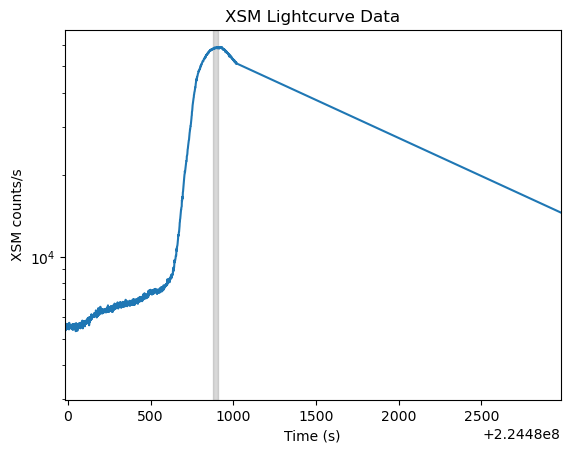

In [39]:
lc_file = '/mnt/c/Users/User/Downloads/ch2_xsm_20240212_v1/xsm/data/2024/02/12/calibrated/ch2_xsm_20240212_v1_level2.lc'
pha = '/mnt/c/Users/User/Downloads/ch2_xsm_20240212_9_spec.pha'

# hdus = fits.open('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.lc')
hdus = fits.open(lc_file)
lc_data = hdus[1].data
tm = lc_data['TIME'] 
rate = lc_data['RATE']


fig, ax = plt.subplots()
ax.errorbar(tm,rate)
ax.set_yscale('log')
plt.axvspan(224480880.216564,224480910.216564,color='grey',alpha=0.3)
ax.set_xlim([224479980.216564,224482980.216564])
ax.set_xlabel('Time (s)')
ax.set_ylabel('XSM counts/s')
ax.set_title('XSM Lightcurve Data')

In [30]:
all_phas = read_pha(pha_file,use_errors=True);
pha = read_pha(pha,use_errors=True)
pha.set_rmf(rmf)
pha.set_analysis('energy')
pha.notice(2.8,15)

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1
print(pha)
#print(f'Number of spectra found: {len(all_phas)}')

read ARF file /mnt/c/Users/User/Downloads/ch2_xsm_20240328_1_spec.arf
read RMF file /home/soumya/xsmdas_directory/xsmdas/caldb/CH2xsmresponse20200423v01.rmf
read ARF file /mnt/c/Users/User/Downloads/ch2_xsm_20240212_9_spec.arf
read RMF file /home/soumya/xsmdas_directory/xsmdas/caldb/CH2xsmresponse20200423v01.rmf
name           = /mnt/c/Users/User/Downloads/ch2_xsm_20240212_9_spec.pha
channel        = Float64[512]
counts         = Float64[512]
staterror      = Float32[512]
syserror       = Float64[512]
bin_lo         = None
bin_hi         = None
grouping       = None
quality        = None
exposure       = None
backscal       = 1.0
areascal       = 1.0
grouped        = False
subtracted     = False
units          = energy
rate           = True
plot_fac       = 0
response_ids   = [1]
background_ids = []


In [31]:



from sherpa.plot import *
from sherpa.astro.plot import DataPHAPlot

In [32]:
rmf = read_rmf('/mnt/c/Users/User/Downloads/CH2xsmrspwitharea_open20191214v01.rsp')

In [33]:
# Define the custom Sherpa model class
class f_vth_sherpa(model.ArithmeticModel):
    def __init__(self, name='f_vth'):
        self.temperature = model.Parameter(name, 'Temperature', 10, min=1, hard_min=0)
        self.em = model.Parameter(name, 'EM', 1, min=1e-5, hard_min=1e-49)
        model.ArithmeticModel.__init__(self, name, (self.temperature, self.em))

    def calc(self, pars, x, *args, **kwargs):
        inds = (x > 1.0002920302956426) & (x < 100)
        x = x[inds]
        x = np.append(x, 2 * x[-1] - x[-2])
        ene = x * u.keV
        temp = pars[0] * 1e6 * u.K
        em = pars[1] * 1e49 / (u.cm**5)

        y = thermal_emission(ene, temp, em)

        spec = np.zeros(len(inds))
        spec[inds] = y

        return spec

mdl = f_vth_sherpa()
ene_x = pha.get_x()
print(mdl)
solexs_rsp = Response1D(pha)
mdl_rsp = solexs_rsp(mdl)
print(mdl_rsp)

f_vth
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_vth.Temperature thawed           10            1  3.40282e+38           
   f_vth.EM     thawed            1        1e-05  3.40282e+38           
apply_rmf(apply_arf(f_vth))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_vth.Temperature thawed           10            1  3.40282e+38           
   f_vth.EM     thawed            1        1e-05  3.40282e+38           


In [34]:


# Load the PHA file and set RMF
pha = read_pha('/mnt/c/Users/User/Downloads/ch2_xsm_20240212_9_spec.pha', use_errors=True)
rmf = read_rmf('/mnt/c/Users/User/Downloads/CH2xsmrspwitharea_open20191214v01.rsp')




pha.set_rmf(rmf)
pha.set_analysis('energy')
pha.notice(2.8,12)

pha.syserror = pha.counts*6e-2 # 6 percent

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1e-5

mdl_rsp.model.pars[0].val = 10# Temperature
mdl_rsp.model.pars[1].val = 0.01 #EM

fi = Fit(pha,mdl_rsp)

fres = fi.fit()
print(fres)
print(f'Reduced Chi2 = {fres.statval/fres.dof:.4f}')

read ARF file /mnt/c/Users/User/Downloads/ch2_xsm_20240212_9_spec.arf
read RMF file /home/soumya/xsmdas_directory/xsmdas/caldb/CH2xsmresponse20200423v01.rmf
datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('f_vth.Temperature', 'f_vth.EM')
parvals        = (14.905546003212562, 80.37969287153423)
statval        = 791.6034587364501
istatval       = 23432.354232519447
dstatval       = 22640.750773783
numpoints      = 280
dof            = 278
qval           = 7.993707338156797e-51
rstat          = 2.847494455886511
message        = successful termination
nfev           = 65
Reduced Chi2 = 2.8475


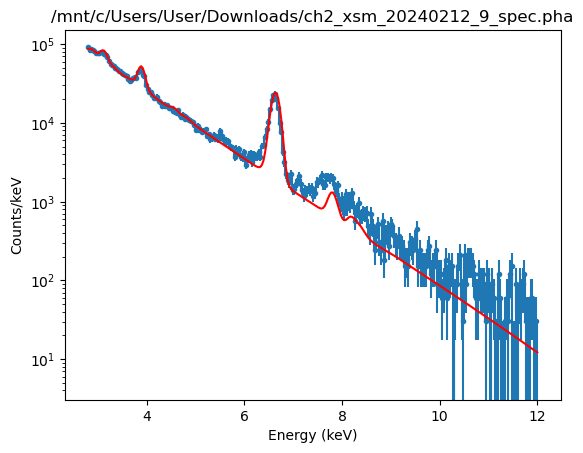

In [35]:

dplot = DataPHAPlot()
dplot.histo_prefs['linestyle'] = '-'
dplot.prepare(fi.data)
mplot = ModelPlot()
mplot.prepare(fi.data, fi.model)
dplot.plot(ylog=True)
mplot.overplot(color='red')


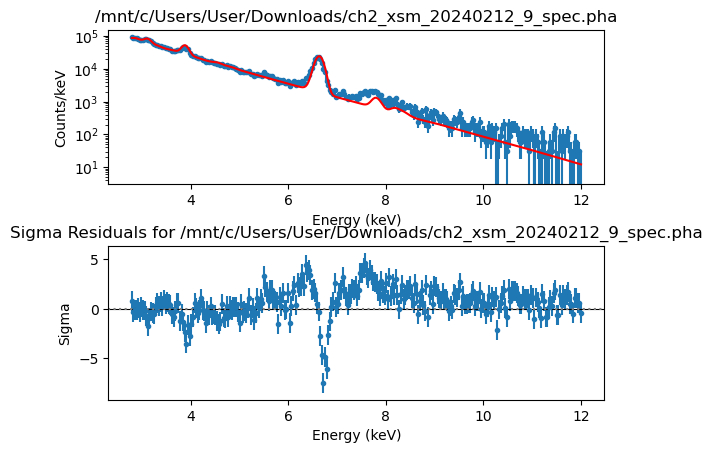

In [36]:
fplot = FitPlot()
rplot = DelchiPlot()
splot = SplitPlot()
dplot = DataPHAPlot()
mplot = ModelPlot()

dplot.prepare(fi.data)
dplot.histo_prefs['linestyle'] = '-'
mplot.prepare(fi.data, fi.model)
mplot.plot_prefs['color'] = 'red'
fplot.prepare(dplot, mplot)
splot.addplot(fplot,ylog=True)
rplot.prepare(fi.data, fi.model, fi.stat)
splot.addplot(rplot)
# the need for a hline call is due to bug #378
rplot.hline(0, linecolor='gray', linestyle='dot', overplot=True)

Text(0.5, 1.0, 'XSM Lightcurve Data')

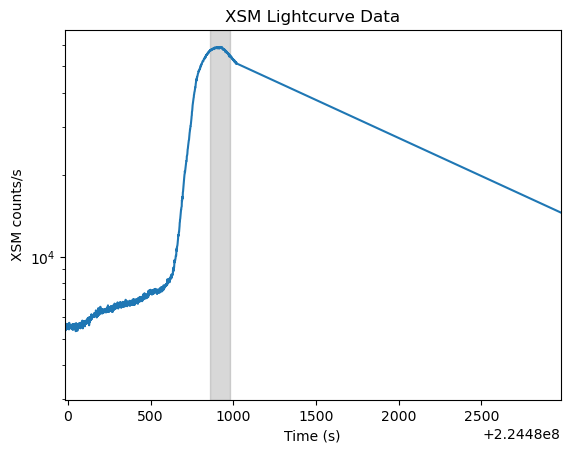

In [43]:
lc_file = '/mnt/c/Users/User/Downloads/ch2_xsm_20240212_v1/xsm/data/2024/02/12/calibrated/ch2_xsm_20240212_v1_level2.lc'
pha = '/mnt/c/Users/User/Downloads/ch2_xsm_20240212_8_spec.pha'

# hdus = fits.open('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.lc')
hdus = fits.open(lc_file)
lc_data = hdus[1].data
tm = lc_data['TIME'] 
rate = lc_data['RATE']


fig, ax = plt.subplots()
ax.errorbar(tm,rate)
ax.set_yscale('log')
plt.axvspan(224480860.216564,224480980.216564,color='grey',alpha=0.3)
ax.set_xlim([224479980.216564,224482980.216564])
ax.set_xlabel('Time (s)')
ax.set_ylabel('XSM counts/s')
ax.set_title('XSM Lightcurve Data')

In [41]:
# Load the PHA file and set RMF
pha = read_pha('/mnt/c/Users/User/Downloads/ch2_xsm_20240212_8_spec.pha', use_errors=True)
rmf = read_rmf('/mnt/c/Users/User/Downloads/CH2xsmrspwitharea_open20191214v01.rsp')




pha.set_rmf(rmf)
pha.set_analysis('energy')
pha.notice(2.8,12)

pha.syserror = pha.counts*6e-2 # 6 percent

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1e-5

mdl_rsp.model.pars[0].val = 10# Temperature
mdl_rsp.model.pars[1].val = 0.01 #EM

fi = Fit(pha,mdl_rsp)

fres = fi.fit()
print(fres)
print(f'Reduced Chi2 = {fres.statval/fres.dof:.4f}')

read ARF file /mnt/c/Users/User/Downloads/ch2_xsm_20240212_8_spec.arf
read RMF file /home/soumya/xsmdas_directory/xsmdas/caldb/CH2xsmresponse20200423v01.rmf
datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('f_vth.Temperature', 'f_vth.EM')
parvals        = (15.125888573979172, 439.3213681487166)
statval        = 1779.000694223479
istatval       = 39101.87710212527
dstatval       = 37322.87640790179
numpoints      = 280
dof            = 278
qval           = 8.132356845485275e-217
rstat          = 6.399283072746328
message        = successful termination
nfev           = 69
Reduced Chi2 = 6.3993


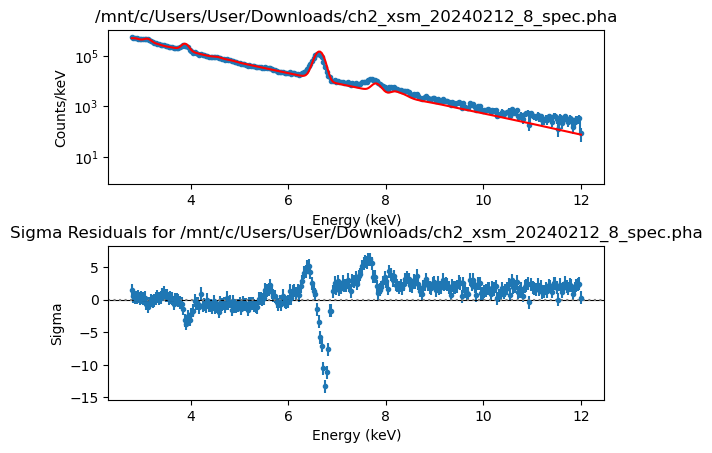

In [42]:
fplot = FitPlot()
rplot = DelchiPlot()
splot = SplitPlot()
dplot = DataPHAPlot()
mplot = ModelPlot()

dplot.prepare(fi.data)
dplot.histo_prefs['linestyle'] = '-'
mplot.prepare(fi.data, fi.model)
mplot.plot_prefs['color'] = 'red'
fplot.prepare(dplot, mplot)
splot.addplot(fplot,ylog=True)
rplot.prepare(fi.data, fi.model, fi.stat)
splot.addplot(rplot)
# the need for a hline call is due to bug #378
rplot.hline(0, linecolor='gray', linestyle='dot', overplot=True)